In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
telecom_data = pd.read_csv('./telecom_churn_data.csv')
telecom_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
telecom_data_67_avg = telecom_data
telecom_data_67_avg['total_rech_6_7_avg'] = (telecom_data_67_avg['total_rech_amt_6'] + telecom_data_67_avg['total_rech_amt_7'])/2
telecom_data_67_avg['total_rech_6_7_avg'].quantile(0.7)


368.5

In [4]:
telecom_data_analysis = telecom_data_67_avg.loc[telecom_data_67_avg['total_rech_6_7_avg'] >= 368.5,:]
telecom_data_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7 to 99997
Columns: 227 entries, mobile_number to total_rech_6_7_avg
dtypes: float64(180), int64(35), object(12)
memory usage: 52.2+ MB


In [5]:
pca = PCA()
scaler = StandardScaler()

In [7]:
for cols in telecom_data_analysis.select_dtypes(include=['object']).columns :
    telecom_data_analysis[cols] = pd.to_datetime(telecom_data_analysis[cols])

In [8]:
telecom_data_analysis.select_dtypes(include=['datetime']).columns

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')

In [9]:
telecom_data_analysis['churn'] = 1

In [10]:
telecom_data_analysis.loc[(telecom_data_analysis.loc[((telecom_data_analysis['total_ic_mou_9'] != 0) | (telecom_data_analysis['total_og_mou_9'] != 0)) & ((telecom_data_analysis['vol_2g_mb_9'] != 0) | (telecom_data_analysis['vol_3g_mb_9'] != 0))].index),'churn'] = 0

In [11]:
telecom_data_analysis['churn'].value_counts()

1    20343
0     9668
Name: churn, dtype: int64

In [12]:
# Drop the columns with _9
cols_to_be_dropped = []
for cols in telecom_data_analysis.columns:
    if cols.endswith('9'):
        cols_to_be_dropped.append(cols)
        
telecom_data_analysis.drop(cols_to_be_dropped,axis=1,inplace=True)        

In [13]:
round(100 * telecom_data_analysis.isnull().sum() / len(telecom_data_analysis.index),2)

mobile_number            0.00
circle_id                0.00
loc_og_t2o_mou           0.38
std_og_t2o_mou           0.38
loc_ic_t2o_mou           0.38
last_date_of_month_6     0.00
last_date_of_month_7     0.10
last_date_of_month_8     0.52
arpu_6                   0.00
arpu_7                   0.00
arpu_8                   0.00
onnet_mou_6              1.05
onnet_mou_7              1.01
onnet_mou_8              3.13
offnet_mou_6             1.05
offnet_mou_7             1.01
offnet_mou_8             3.13
roam_ic_mou_6            1.05
roam_ic_mou_7            1.01
roam_ic_mou_8            3.13
roam_og_mou_6            1.05
roam_og_mou_7            1.01
roam_og_mou_8            3.13
loc_og_t2t_mou_6         1.05
loc_og_t2t_mou_7         1.01
loc_og_t2t_mou_8         3.13
loc_og_t2m_mou_6         1.05
loc_og_t2m_mou_7         1.01
loc_og_t2m_mou_8         3.13
loc_og_t2f_mou_6         1.05
                        ...  
arpu_3g_7               61.14
arpu_3g_8               60.83
arpu_2g_6 

In [14]:
# drop all the columns that has more than 50%
telecom_data_analysis.dropna(axis=1,thresh=15000,inplace=True)

In [15]:
round(100 * telecom_data_analysis.isnull().sum() / len(telecom_data_analysis.index),2)

mobile_number           0.00
circle_id               0.00
loc_og_t2o_mou          0.38
std_og_t2o_mou          0.38
loc_ic_t2o_mou          0.38
last_date_of_month_6    0.00
last_date_of_month_7    0.10
last_date_of_month_8    0.52
arpu_6                  0.00
arpu_7                  0.00
arpu_8                  0.00
onnet_mou_6             1.05
onnet_mou_7             1.01
onnet_mou_8             3.13
offnet_mou_6            1.05
offnet_mou_7            1.01
offnet_mou_8            3.13
roam_ic_mou_6           1.05
roam_ic_mou_7           1.01
roam_ic_mou_8           3.13
roam_og_mou_6           1.05
roam_og_mou_7           1.01
roam_og_mou_8           3.13
loc_og_t2t_mou_6        1.05
loc_og_t2t_mou_7        1.01
loc_og_t2t_mou_8        3.13
loc_og_t2m_mou_6        1.05
loc_og_t2m_mou_7        1.01
loc_og_t2m_mou_8        3.13
loc_og_t2f_mou_6        1.05
                        ... 
date_of_last_rech_7     0.38
date_of_last_rech_8     1.98
last_day_rch_amt_6      0.00
last_day_rch_a

In [16]:
telecom_data_analysis.drop(['mobile_number','circle_id'],axis=1,inplace=True)

In [17]:
telecom_data_analysis.dropna(inplace=True)
col_scale = list(telecom_data_analysis.select_dtypes(include=['int','float']))
X = telecom_data_analysis.loc[:,col_scale]
y = telecom_data_analysis.loc[:,'churn']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)

In [19]:
#temp = X_train.fillna(0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
x_pca = pca.fit_transform(X_train)
lr = LogisticRegression()
lr.fit(x_pca,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
x_test_pca = pca.transform(X_test)
y_pred = lr.predict(x_test_pca)

In [22]:
metrics.confusion_matrix(y_test,y_pred)

array([[2911,    0],
       [   0, 5636]])

In [23]:
metrics.recall_score(y_test,y_pred)

1.0

In [24]:
metrics.accuracy_score(y_test,y_pred)

1.0

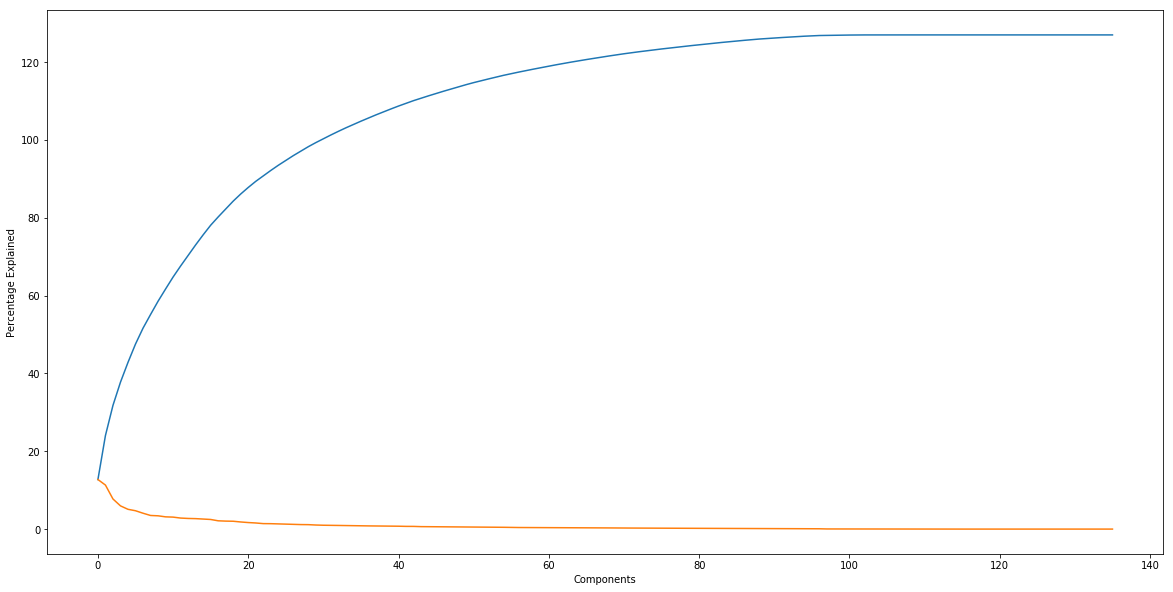

In [25]:
plt.figure(figsize=(20,10))
plt.xlabel('Components')
plt.ylabel('Percentage Explained')
plt.plot(np.cumsum(pca.explained_variance_))
plt.plot(pca.explained_variance_)
plt.show()


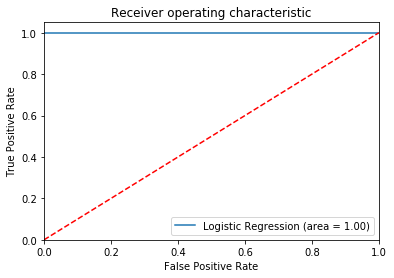

In [26]:
# ROC curve - Logistics
logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
#fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
xgb = XGBClassifier()

In [28]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
y_pred_xgb = xgb.predict(X_test)

In [30]:
metrics.confusion_matrix(y_test,y_pred_xgb)

array([[2911,    0],
       [   0, 5636]])

In [31]:
metrics.accuracy_score(y_test,y_pred_xgb)

1.0

In [32]:
metrics.recall_score(y_test,y_pred_xgb)

1.0

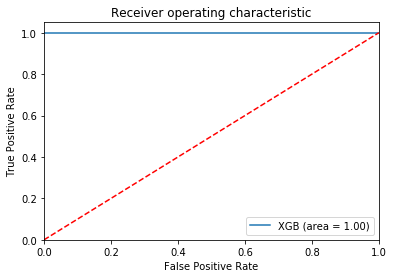

In [33]:
# ROC - XGB
logit_roc_auc = metrics.roc_auc_score(y_test, y_pred_xgb)
#fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_xgb)
plt.figure()
plt.plot(fpr, tpr, label='XGB (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred_rfc = rfc.predict(X_test)

In [35]:
metrics.confusion_matrix(y_test,y_pred_rfc)

array([[2910,    1],
       [  19, 5617]])

In [36]:
metrics.accuracy_score(y_test,y_pred_rfc)

0.9976599976599977

In [37]:
metrics.recall_score(y_test,y_pred_rfc)

0.9966288147622427

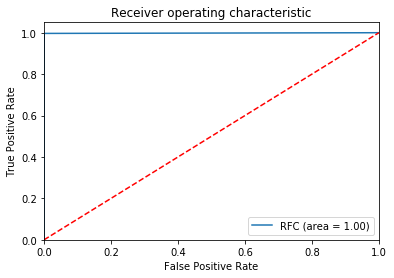

In [38]:
# ROC - XGB
logit_roc_auc = metrics.roc_auc_score(y_test, y_pred_rfc)
#fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rfc)
plt.figure()
plt.plot(fpr, tpr, label='RFC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [40]:
# Grid Search for RFC
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                   cv = n_folds,  
                   scoring="accuracy")
rf.fit(X_train, y_train)



GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(100, 1500, 400)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

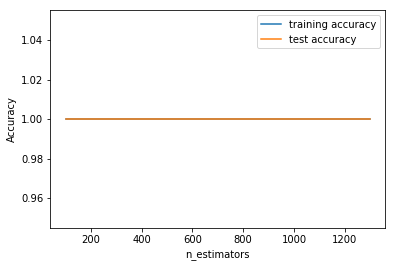

In [41]:
scores = rf.cv_results_
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()





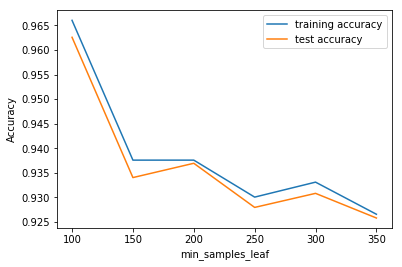

In [42]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv = n_folds,
                   scoring="accuracy")
rf.fit(X_train, y_train)

scores = rf.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

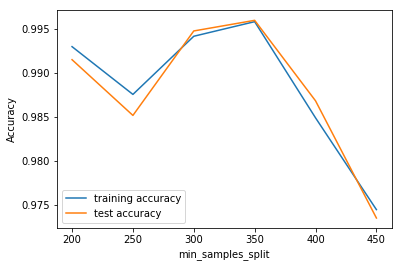

In [43]:
# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters,  
                   scoring="accuracy")
rf.fit(X_train, y_train)

scores = rf.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(10, 20, 1)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                  cv = n_folds,
                   scoring="accuracy")
rf.fit(X_train, y_train)

scores = rf.cv_results_
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

